In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0d4f7369d4363a1698c235136d1403105b5361591c2dced299e65a8161d9f39f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
import shap
from sklearn.tree import export_text
from lime.lime_tabular import LimeTabularExplainer
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
rf = joblib.load("best_random_forest.pkl")

In [ ]:
df = pd.read_csv("cosmic_clinvar_processed.tsv", sep="\t")

In [ ]:
X = df.drop(columns=['Label'])
Y = df['Label']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train - test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [ ]:
Y_pred_test = rf.predict(X_test)
Y_pred_prob = rf.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Accuracy
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# F1-Score
test_f1 = f1_score(Y_test, Y_pred_test)
print(f"Test F1-Score: {test_f1:.4f}")

# ROC-AUC
test_roc_auc = roc_auc_score(Y_test, Y_pred_prob)
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.9666
Test F1-Score: 0.9804
Test ROC-AUC: 0.9933


In [ ]:
# Store feature names before scaling
feature_names = df.drop(columns=['Label']).columns

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to rank features
feature_importance_df = pd.DataFrame({
    "Feature": X_train_df.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display top features
print(feature_importance_df)

                                              Feature    Importance
20                                 synonymous_variant  1.428460e-01
7                                    AA_Length_Change  1.419902e-01
1                                        GENOME_START  1.217438e-01
2                                         GENOME_STOP  1.161229e-01
25                                   missense_variant  8.725738e-02
28                                       Gene_Encoded  7.950181e-02
5                               Hydrophobicity_Change  7.784315e-02
4                                      BLOSUM62_Score  6.072620e-02
0                                          CHROMOSOME  5.579736e-02
31  MUTATION_SOMATIC_STATUS_Variant of unknown origin  2.167690e-02
6                                       Charge_Change  1.904071e-02
24                                        stop_gained  1.502206e-02
30  MUTATION_SOMATIC_STATUS_Reported in another ca...  1.182839e-02
12                              Genomic_Length_C

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Sample 1000 rows
X_sample = X_test_df.sample(1000, random_state=42)  # Add random_state for reproducibility

# Create SHAP explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

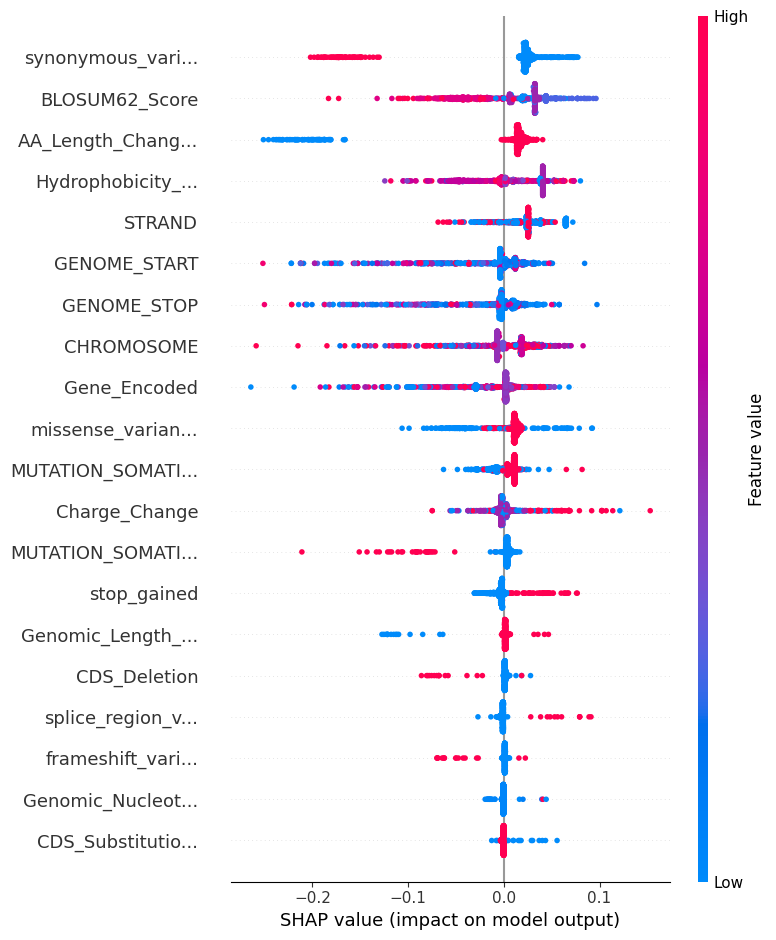

In [ ]:
 # "Pathogenic": 1, "Benign": 0
shap_values_class_1 = shap_values[:, :, 1]  # Extract SHAP values for class 1

short_feature_names = [name[:15] + "..." if len(name) > 15 else name for name in feature_names]
shap.summary_plot(shap_values_class_1, X_sample, feature_names=short_feature_names)

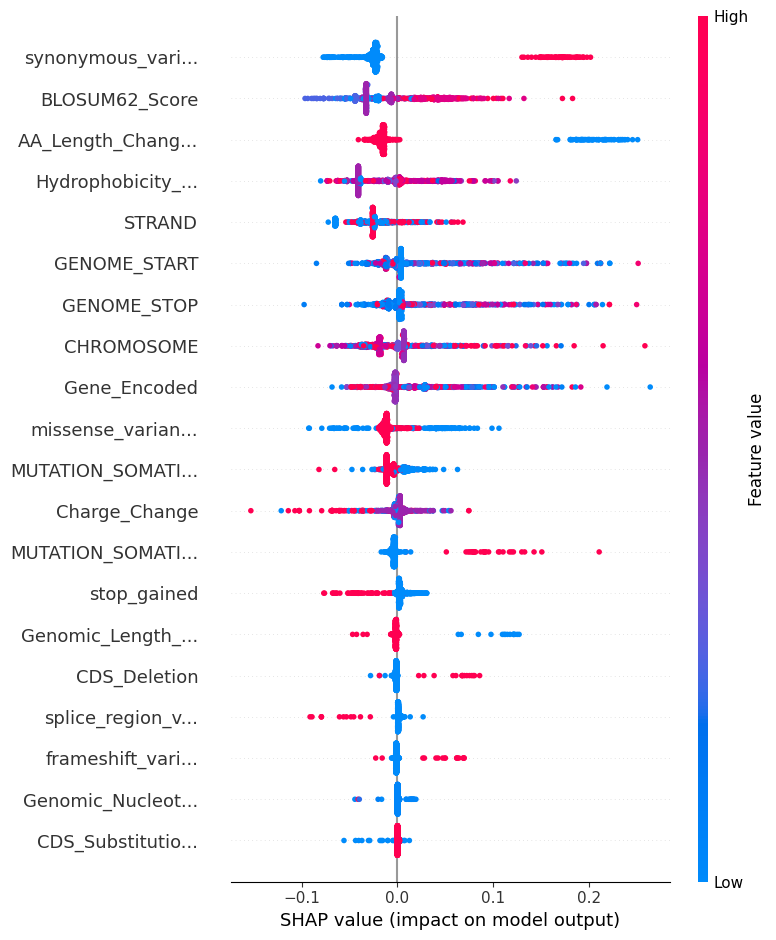

In [ ]:
shap_values_class_1 = shap_values[:, :, 0]  # Extract SHAP values for class 1

short_feature_names = [name[:15] + "..." if len(name) > 15 else name for name in feature_names]
shap.summary_plot(shap_values_class_1, X_sample, feature_names=short_feature_names)

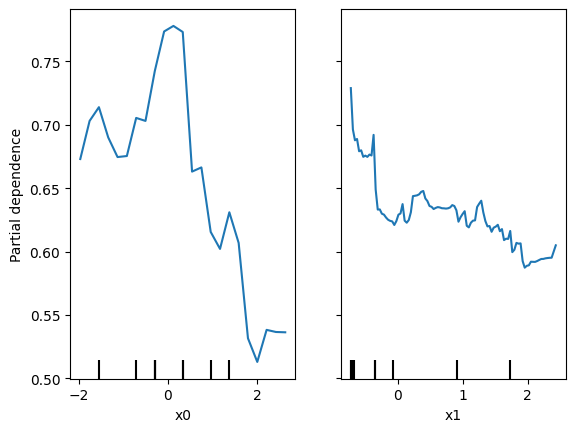

In [ ]:
features = [0, 1]
PartialDependenceDisplay.from_estimator(rf, X_test, features)
plt.show()

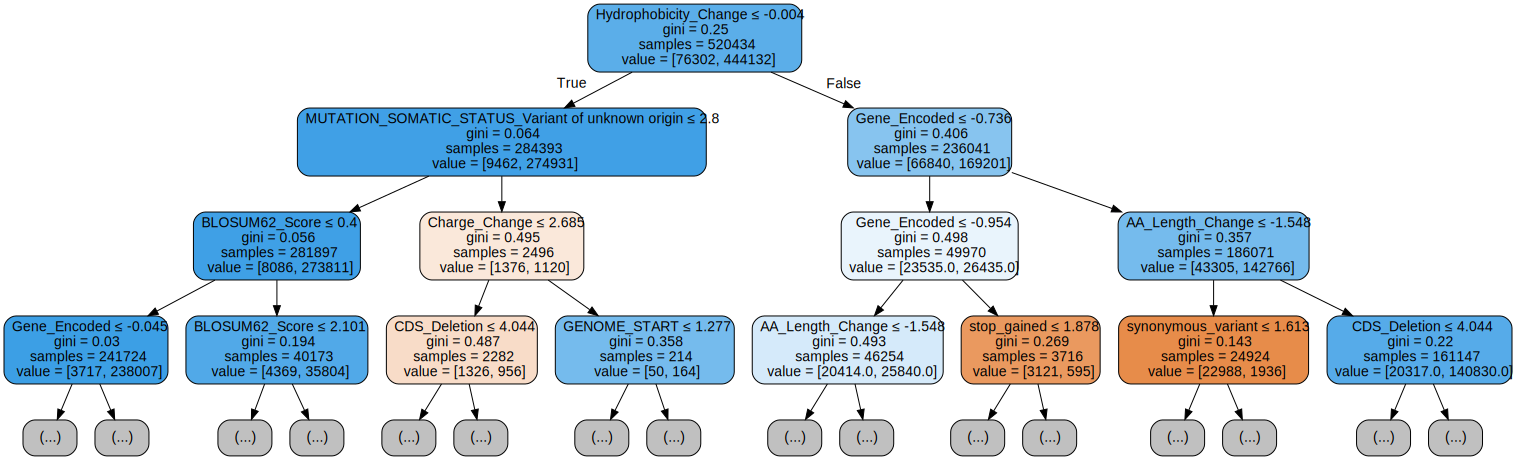

In [ ]:
# Export tree structure to DOT format
dot_data = export_graphviz(
    rf.estimators_[0],  # Extract one tree
    feature_names=list(feature_names),
    filled=True,
    rounded=True,
    max_depth=3,  # Limit depth for clarity
    special_characters=True
)

# Render the tree with Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Saves as 'decision_tree.pdf'
graph

In [ ]:
explainer = LimeTabularExplainer(X_train, feature_names=feature_names, class_names=["Benign", "Driver"], mode="classification")
exp = explainer.explain_instance(X_test_df.iloc[0], rf.predict_proba)
exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.